In [1]:
import numpy as np
from numpy.random import poisson, normal, uniform
from scipy import optimize
from matplotlib import pyplot as plt
%matplotlib inline


# FF chi2
def chi2(t, d, aa):
    return np.sum((np.dot(aa,t)-d)**2)

# FF Poisson
def pois(t, d, aa):
    return -np.sum(d*np.log(np.dot(aa,t))-np.dot(aa,t))

# FF Poisson with > 0 requirement
def pois_reg(t, d, aa):
    if np.any(t<0):
        return np.inf
    return -np.sum(d*np.log(np.dot(aa,t))-np.dot(aa,t))

# UF iterative
def itunf(nit, d, p, aa):
    if nit == 0:
        return p
    uu = (np.copy(aa)*p/np.sum(p)).T
    uu /= np.sum(uu, axis=0)
    np.nan_to_num(uu, copy=False)
    p = np.dot(uu,d)

    return itunf(nit-1, d, p, aa)

def plot(d, tauhat, fout):
    plt.plot(d, 'k+', label=r'$d$')
    plt.plot(tauhat, 'o', label=r'$\hat{\tau}$')
    plt.xlabel('Bin')
    plt.ylabel('N')
    plt.legend()
    plt.savefig(fout, dpi=300)

In [2]:
# FF matrix
A = np.array([[2/3., 0, 0],
              [1/3., 2/3., 0],
              [0,1/3.,1]])
Ainv = np.linalg.inv(A)

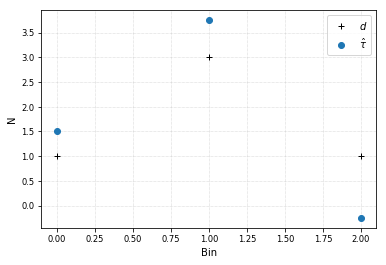

In [3]:
d = np.asarray([1,3,1])
res = optimize.minimize(chi2, [1,1,1], args=(d, A))
plot(d, res.x, 'chi2.png')

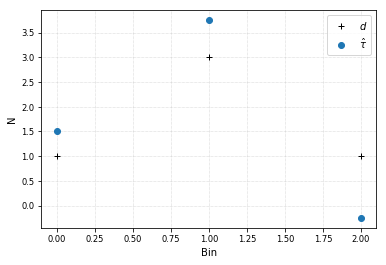

In [4]:
d = np.asarray([1,3,1])
res = optimize.minimize(pois, [1,1,1], args=(d, A))
plot(d, res.x, 'pois.png')

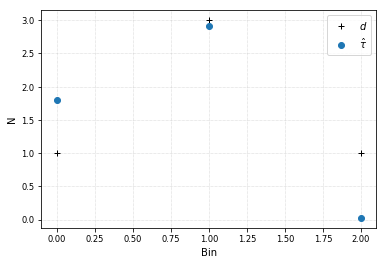

In [5]:
d = np.asarray([1,3,1])
res = optimize.minimize(pois_reg, [1,1,1], args=(d, A))
plot(d, res.x, 'pois_reg.png')

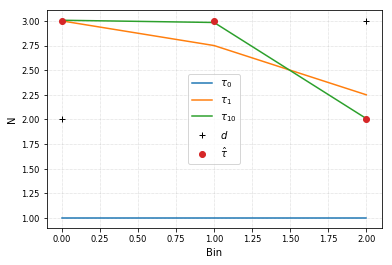

In [7]:
d = np.asarray([2.,3.,3.])
[plt.plot(itunf(it, d, np.ones(d.size), A), label=r'$\tau_{{{}}}$'.format(it)) for it in [0,1,10]]
plot(d, np.dot(Ainv,d), 'itunf.png')

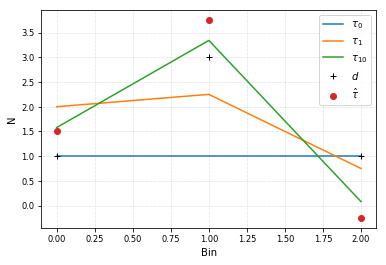

In [8]:
d = np.asarray([1.,3.,1.])
[plt.plot(itunf(it, d, np.ones(d.size), A), label=r'$\tau_{{{}}}$'.format(it)) for it in [0,1,10]]
plot(d, np.dot(Ainv,d), 'itunf_2.png')

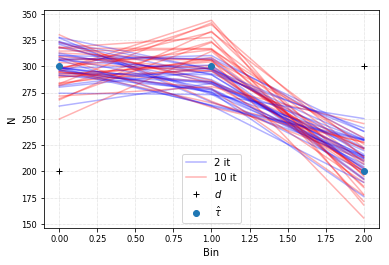

In [9]:
d = np.asarray([200,300.,300.])
for i in range(30):
    s = poisson(d)
    for nit, color in zip([2, 10], ['b','r']):
        label= '{} it'.format(nit) if i == 0 else None
        plt.plot(itunf(nit, s, np.ones(d.size), A), color=color, alpha=0.3, label=label)
plot(d, np.dot(Ainv,d), 'itunf_err.png')

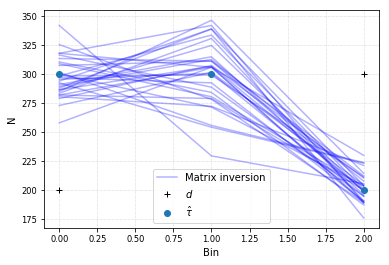

In [10]:
for i in range(30):
    s = poisson(d)
    label = 'Matrix inversion' if i == 0 else None
    plt.plot(np.dot(Ainv, s), color='b', alpha=0.3, label=label)
plot(d, np.dot(Ainv,d), 'ivunf_err.png')

In [11]:
def make_events(true_energy, energy):                                                                                                                                                                                                  
    return np.array(zip(true_energy, energy),                                                                                                                                                                                          
                    dtype=[('et', 'f4'),('er', 'f4')]) 

def generate_data(n, mu, s, offset, smear):
    te = normal(mu, s, n)
    e = te+normal(offset, smear, n)
    
    return make_events(te, e)

def generate_mc(n, low, high, offset, smear):
    te = uniform(low, high, n)
    e = te+normal(offset, smear, n)
    
    return make_events(te, e)

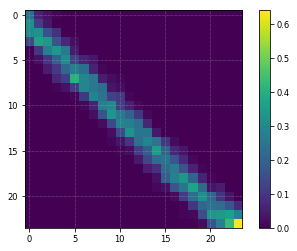

In [12]:
mc = generate_mc(2000, 50, 150, 5, 5)
data = generate_data(500, 100, 10, 5, 5)

bins = np.linspace(50, 150, 25)
centers = (bins[:-1]+bins[1:])/2.

hdata, _ = np.histogram(data['er'], bins=bins)
htrue, _ = np.histogram(data['et'], bins=bins)

hmc_reco, _ = np.histogram(mc['er'], bins=bins)
hmc_true, _ = np.histogram(mc['et'], bins=bins)

Amc, redges, tedges = np.histogram2d(mc['er'], mc['et'], bins=bins)
Amc /= np.sum(Amc, axis=0)
plt.imshow(Amc)
plt.colorbar()

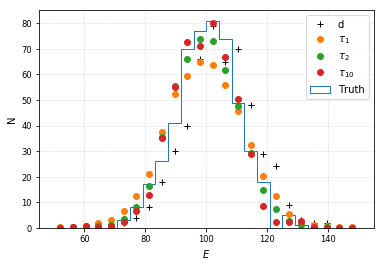

In [13]:
plt.hist(data['et'], tedges, histtype='step', label='Truth')
plt.plot(centers, hdata, 'k+', label='d')
[plt.plot(centers, itunf(it, hdata, np.ones(hdata.size), Amc), 'o', label=r'$\tau_{{{}}}$'.format(it)) for it in [1,2,10]]
plt.xlabel(r'$E$')
plt.ylabel('N')
plt.legend()
plt.savefig('itunf_toy.png', dpi=300)

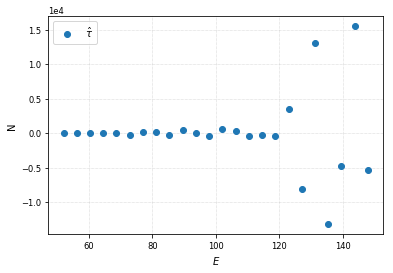

In [14]:
plt.plot(centers, np.dot(np.linalg.inv(Amc),hdata), 'o', label=r'$\hat{\tau}$')
plt.xlabel(r'$E$')
plt.ylabel('N')
plt.legend()
plt.savefig('ivunf_toy.png', dpi=300)